# 🎬 Movie Recommender System with Fuzzy Search in Python

This project builds a movie recommendation engine using natural language processing and machine learning techniques.

It recommends movies similar to a user’s input based on the movie plot summaries using:

- **TF-IDF Vectorization** to convert text to numeric features
- **Cosine Similarity** to find similar movies
- **Fuzzy matching** to allow partial or misspelled movie title input

---

### Why this project?

Building a recommender system is a classic problem in Data Science and helps understand text processing, similarity measures, and interactive user inputs.


In [64]:
# Import Necessary Libraries

import pandas as pd
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


### The dataset contains movie information including the movie title and plot summary (overview). 
We will use the 'Series_Title' column for titles and 'Overview' for plot descriptions.


In [111]:
# Load movie dataset
movies = pd.read_csv('movies.csv')  # Replace with your dataset path

# Show first 5 rows to understand data
movies.head()


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


### We remove movies with missing plot summaries to avoid errors during text processing.


In [119]:
# Check for missing values and drop if any in the overview column
movies = movies.dropna(subset=['Overview'])

# Reset index after dropping rows
movies = movies.reset_index(drop=True)


### TF-IDF (Term Frequency-Inverse Document Frequency) converts each movie's plot into a vector that numerically represents the importance of words while ignoring common English stopwords.


In [72]:
# Convert overview text to TF-IDF vectors
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['Overview'])

# Shape of matrix (rows = movies, cols = words)
tfidf_matrix.shape


(1000, 5426)

### The table shows how the first 10 movies are vectorized using the TF-IDF technique.

- Each row is a movie.
- Each column is a word (feature).
- Higher values mean the word is more relevant to that movie.
We only display the top 15 features for clarity.


In [128]:
# Convert to dense DataFrame (first 10 movies only)
tfidf_dense = pd.DataFrame(tfidf_matrix[:10].toarray(), columns=tfidf.get_feature_names_out())

# Select only columns (words) where at least 1 movie has a non-zero TF-IDF value
non_zero_cols = tfidf_dense.loc[:, (tfidf_dense != 0).any(axis=0)]

# Show first 10 movies × first 15 non-zero words
non_zero_cols.iloc[:, :15].style.background_gradient(cmap='YlGnBu')


,1920s,ability,accept,acts,aging,approach,aragorn,army,attempts,bandits,batman,bond,boxer,care,career
0,0.000000,0.000000,0.000000,0.318048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.257369,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.271455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.267454,0.267454,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.233491,0.000000,0.000000,0.000000,0.000000
3,0.264819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.216964
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.265208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.277308,0.293819,0.209144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.295701,0.000000,0.000000,0.268109,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256247,0.000000


### Cosine similarity measures how similar two movie plots are by calculating the cosine of the angle between their TF-IDF vectors.  
The result is a similarity matrix where each element [i, j] represents similarity between movie i and movie j.


In [131]:
# Compute cosine similarity between all movie vectors
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


### The heatmap visualizes cosine similarity between the first 15 movies.  
Lighter shades mean stronger similarity.  
This shows which movies have plots that are closely related.


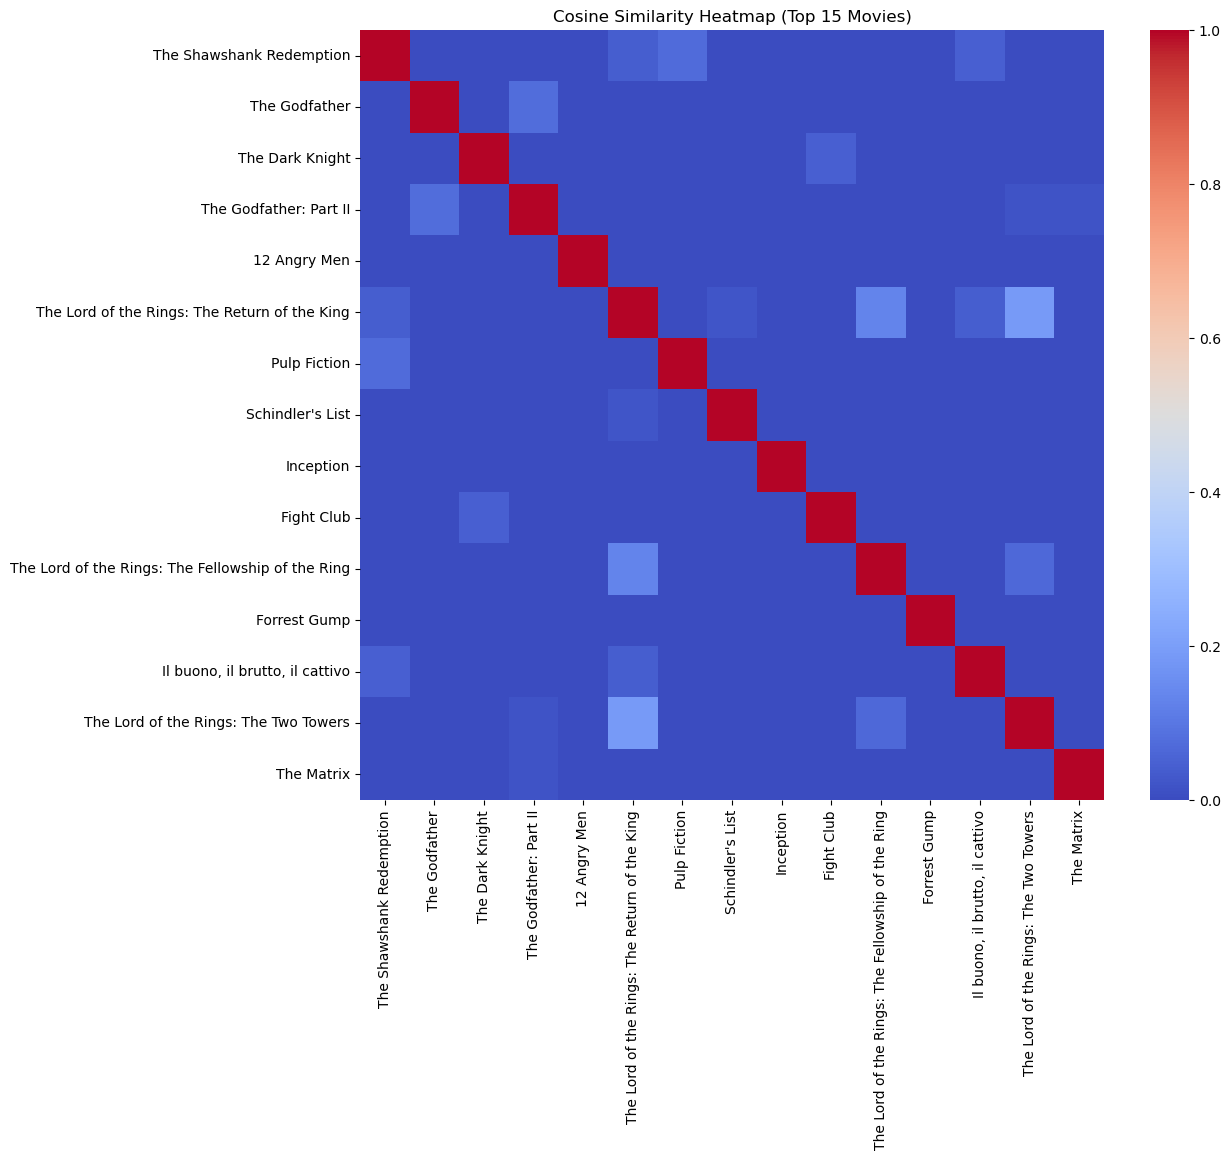

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
# Display similarity matrix of first 15 movies
plt.figure(figsize=(12, 10))
sns.heatmap(cosine_sim[:15, :15], 
            xticklabels=movies['Series_Title'][:15], 
            yticklabels=movies['Series_Title'][:15], 
            cmap='coolwarm', 
            annot=False)
plt.title('Cosine Similarity Heatmap (Top 15 Movies)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


### This map allows us to quickly find the index of a movie in the dataset by its title.


In [140]:
# Create a Series mapping movie titles to their indices
indices = pd.Series(movies.index, index=movies['Series_Title']).drop_duplicates()


### The recommendation function:

- Takes user input (movie title)
- Uses fuzzy matching to find the closest matching movie title in the dataset
- Finds movies with the most similar plots using cosine similarity
- Displays the top recommendations


In [147]:

def recommend_movies(num_recommendations=5):
    title = input("🎬 Enter the name of a movie you like: ").strip().lower()

    possible_matches = difflib.get_close_matches(title, movies['Series_Title'].str.lower(), n=1, cutoff=0.4)

    if not possible_matches:
        print("❌ Sorry! Movie not found. Try typing more of the title.")
        return

    actual_title = movies['Series_Title'][movies['Series_Title'].str.lower() == possible_matches[0]].values[0]
    
    print(f"🎯 Interpreted your input as: '{actual_title}'")

    idx = indices[actual_title]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations+1]

    movie_indices = [i[0] for i in sim_scores]
    recommended = movies['Series_Title'].iloc[movie_indices]

    print(f"\nBecause you searched for '{actual_title}', you may also like:\n")
    for i, rec in enumerate(recommended):
        print(f"{i+1}. 🎬 {rec}")


### Try typing a movie name (partial names and minor typos are allowed), and get top 5 movie recommendations!


In [150]:
recommend_movies()


🎬 Enter the name of a movie you like:  The Dark Knight


🎯 Interpreted your input as: 'The Dark Knight'

Because you searched for 'The Dark Knight', you may also like:

1. 🎬 Batman Begins
2. 🎬 The Dark Knight Rises
3. 🎬 Joker
4. 🎬 Kill Bill: Vol. 1
5. 🎬 La battaglia di Algeri


In [152]:
recommend_movies()


🎬 Enter the name of a movie you like:  Shawshank


🎯 Interpreted your input as: 'The Shawshank Redemption'

Because you searched for 'The Shawshank Redemption', you may also like:

1. 🎬 Dev.D
2. 🎬 Oldeuboi
3. 🎬 The Great Escape
4. 🎬 Fa yeung nin wah
5. 🎬 Koe no katachi


In [154]:
recommend_movies()

🎬 Enter the name of a movie you like:  titanic


🎯 Interpreted your input as: 'Titanic'

Because you searched for 'Titanic', you may also like:

1. 🎬 Call Me by Your Name
2. 🎬 The Notebook
3. 🎬 Laura
4. 🎬 As Good as It Gets
5. 🎬 The Straight Story
